In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch

# Necessary for loading data and modeling in PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from itertools import product

# Load Data

In [4]:
df = pd.read_csv('Etiquetas.csv')
df

,age_group,MMSE_Score,Gender
0,2,30,1
1,2,30,1
2,2,30,1
3,2,30,1
4,2,30,1
...,...,...,...
795,2,30,1
796,2,30,1
797,2,30,1
798,2,30,1


In [7]:

X = torch.tensor(np.load("/content/data LSTM.npy"))
X.shape

y = torch.tensor(np.load("/content/Rel Match Label.npy"))
y.shape

torch.Size([800])

# Model

In [59]:
class LSTMRegression(torch.nn.Module):

    def __init__(self,n_features,seq_length, n_hidden, n_layers):
        super(LSTMRegression, self).__init__()

        self.n_features = n_features
        self.seq_len = seq_length
        self.n_hidden = n_hidden
        self.n_layers = n_layers

        self.l_lstm = torch.nn.LSTM(input_size = self.n_features,
                                 hidden_size = self.n_hidden,
                                 num_layers = self.n_layers,
                                 batch_first = True, dropout=0.3)


        self.l_linear = torch.nn.Linear(self.n_hidden, 1)



    def forward(self, x):
        batch_size, seq_len, _ = x.size()
        x, (self.hidden, _) = self.l_lstm(x)
        return self.l_linear(x[:,-1,:])


# Train

In [66]:

def makeSplits(data, label):
    # Define the percentages for splits
    perc = [0.7, 0.2, 0.1]

    # Calculate the sizes for each split
    sizes = [int(perc[i] * len(data)) for i in range(len(perc))]

    train, val, test = sizes[0], sizes[1], sizes[2]

    # Slice the data tensor (3D) and label tensor (1D) for each split
    X_train = data[:train, :, :]
    y_train = label[:train]
    X_val = data[train:train + val, :, :]
    y_val = label[train:train + val]
    X_test = data[train + val:train + val + test, :, :]
    y_test = label[train + val:train + val + test]

    return X_train, y_train, X_val, y_val, X_test, y_test


def train_model(model, train_loader, X_val, y_val, criterion, num_epochs, learning_rate, patience=3):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate,weight_decay=1e-4)
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    # Early stopping variables
    best_val_loss = float('inf')
    best_model = None
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        epoch_loss, correct_train, total_train = 0, 0, 0

        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch)

            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()

            # Training accuracy (threshold logits at 0.5)
            y_pred_class = torch.sigmoid(y_pred) >= 0.5
            correct_train += (y_pred_class == y_batch).sum().item()
            total_train += y_batch.size(0)

            epoch_loss += loss.item()

        train_losses.append(epoch_loss / len(train_loader))
        train_accuracies.append(correct_train / total_train * 100)

        # Validation
        model.eval()
        with torch.no_grad():
            y_val_pred = model(X_val)
            val_loss = criterion(y_val_pred, y_val).item()
            val_losses.append(val_loss)

            # Validation accuracy
            y_val_pred_class = torch.sigmoid(y_val_pred) >= 0.5
            correct_val = (y_val_pred_class == y_val).sum().item()
            val_accuracies.append(correct_val / y_val.size(0) * 100)

        print(
            f"Epoch {epoch+1}/{num_epochs}, "
            f"Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, "
            f"Train Acc: {train_accuracies[-1]:.2f}%, Val Acc: {val_accuracies[-1]:.2f}%"
        )

        # Early stopping check
        if val_losses[-1] < best_val_loss:
            best_val_loss = val_losses[-1]
            best_model = model.state_dict()
            patience_counter = 0  # Reset patience
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    # Return the best model and metrics
    model.load_state_dict(best_model)  # Load the best model
    return train_losses, val_losses, train_accuracies, val_accuracies



# Plot Metrics
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    axes[0, 0].plot(epochs, train_losses, label="Train Loss", color="blue")
    axes[0, 0].plot(epochs, val_losses, label="Validation Loss", color="green")
    axes[0, 0].set_title("Training Loss")
    axes[0, 0].legend()

    axes[0, 1].plot(epochs, train_accuracies, label="Train Accuracy", color="red")
    axes[0, 1].set_title("Training Accuracy")
    axes[0, 1].legend()

    axes[1, 0].plot(epochs, val_losses, label="Validation Loss", color="green")
    axes[1, 0].set_title("Validation Loss")
    axes[1, 0].legend()

    axes[1, 1].plot(epochs, val_accuracies, label="Validation Accuracy", color="purple")
    axes[1, 1].set_title("Validation Accuracy")
    axes[1, 1].legend()

    plt.tight_layout()
    plt.show()

def pipeline(data, label):
    # Splits
    X_train, y_train, X_val, y_val, X_test, y_test = makeSplits(data, label)

    # Convert to tensors
    X_train, y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long)
    X_val, y_val = torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.long)

    y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
    y_val = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)


    train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train, y_train), batch_size=32, shuffle=True)

    # Hyperparameter search space
    learning_rates = [0.0001, 0.005, 0.001]
    hidden_sizes = [8,16,20, 32]
    num_layers_list = [1, 2, 3]


    learning_rates = [0.0001,0.00001]
    hidden_sizes = [8, 16, 20]
    num_layers_list = [1, 2, 3]


    # Best model tracking
    best_val_accuracy = 0
    best_metrics = None
    best_model = None

    criterion = nn.BCEWithLogitsLoss()

    for lr, hidden_size, num_layers in product(learning_rates, hidden_sizes, num_layers_list):
        print(f"\nTesting Model: lr={lr}, hidden_size={hidden_size}, num_layers={num_layers}")
        model = LSTMRegression(n_features=X_train.shape[2], seq_length=X_train.shape[1], n_hidden=hidden_size, n_layers=num_layers)

        # Train model
        train_losses, val_losses, train_accuracies, val_accuracies = train_model(
            model, train_loader, X_val, y_val, criterion, num_epochs=50, learning_rate=lr
        )

        # Track best model
        if max(val_accuracies) > best_val_accuracy:
            best_val_accuracy = max(val_accuracies)
            best_metrics = (train_losses, val_losses, train_accuracies, val_accuracies)
            best_model = model.state_dict()
            print(f"New Best Model Found: Val Accuracy = {best_val_accuracy:.2f}%")

    # Save the best model
    torch.save(best_model, "best_model.pth")
    print(f"\nBest Model Saved with Validation Accuracy: {best_val_accuracy:.2f}%")

    # Plot the best model
    if best_metrics:
        train_losses, val_losses, train_accuracies, val_accuracies = best_metrics
        plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)


In [48]:
import torch
import numpy as np

# Call the function
X_train, y_train, X_val, y_val, X_test, y_test = makeSplits(X, y)

# Print shapes to verify
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val:", X_val.shape, "y_val:", y_val.shape)
print("X_test:", X_test.shape, "y_test:", y_test.shape)


X_train: torch.Size([560, 51, 360]) y_train: torch.Size([560])
X_val: torch.Size([160, 51, 360]) y_val: torch.Size([160])
X_test: torch.Size([80, 51, 360]) y_test: torch.Size([80])


<ipython-input-66-cd30d73c56ca>:120: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train, y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long)
<ipython-input-66-cd30d73c56ca>:121: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val, y_val = torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.long)
<ipython-input-66-cd30d73c56ca>:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
<ipython-input-66-cd30d73c56ca>


Testing Model: lr=0.0001, hidden_size=8, num_layers=1
Epoch 1/50, Train Loss: 0.7048, Val Loss: 0.6936, Train Acc: 51.07%, Val Acc: 55.00%
Epoch 2/50, Train Loss: 0.6984, Val Loss: 0.6921, Train Acc: 51.79%, Val Acc: 55.00%
Epoch 3/50, Train Loss: 0.6967, Val Loss: 0.6909, Train Acc: 52.32%, Val Acc: 56.25%
Epoch 4/50, Train Loss: 0.6954, Val Loss: 0.6897, Train Acc: 53.39%, Val Acc: 56.25%
Epoch 5/50, Train Loss: 0.6912, Val Loss: 0.6886, Train Acc: 53.93%, Val Acc: 56.25%
Epoch 6/50, Train Loss: 0.6887, Val Loss: 0.6877, Train Acc: 54.64%, Val Acc: 55.62%
Epoch 7/50, Train Loss: 0.6890, Val Loss: 0.6867, Train Acc: 55.00%, Val Acc: 56.88%
Epoch 8/50, Train Loss: 0.6861, Val Loss: 0.6858, Train Acc: 56.25%, Val Acc: 56.88%
Epoch 9/50, Train Loss: 0.6844, Val Loss: 0.6848, Train Acc: 56.96%, Val Acc: 57.50%
Epoch 10/50, Train Loss: 0.6790, Val Loss: 0.6838, Train Acc: 57.50%, Val Acc: 57.50%
Epoch 11/50, Train Loss: 0.6780, Val Loss: 0.6828, Train Acc: 58.57%, Val Acc: 57.50%
Epoch 12

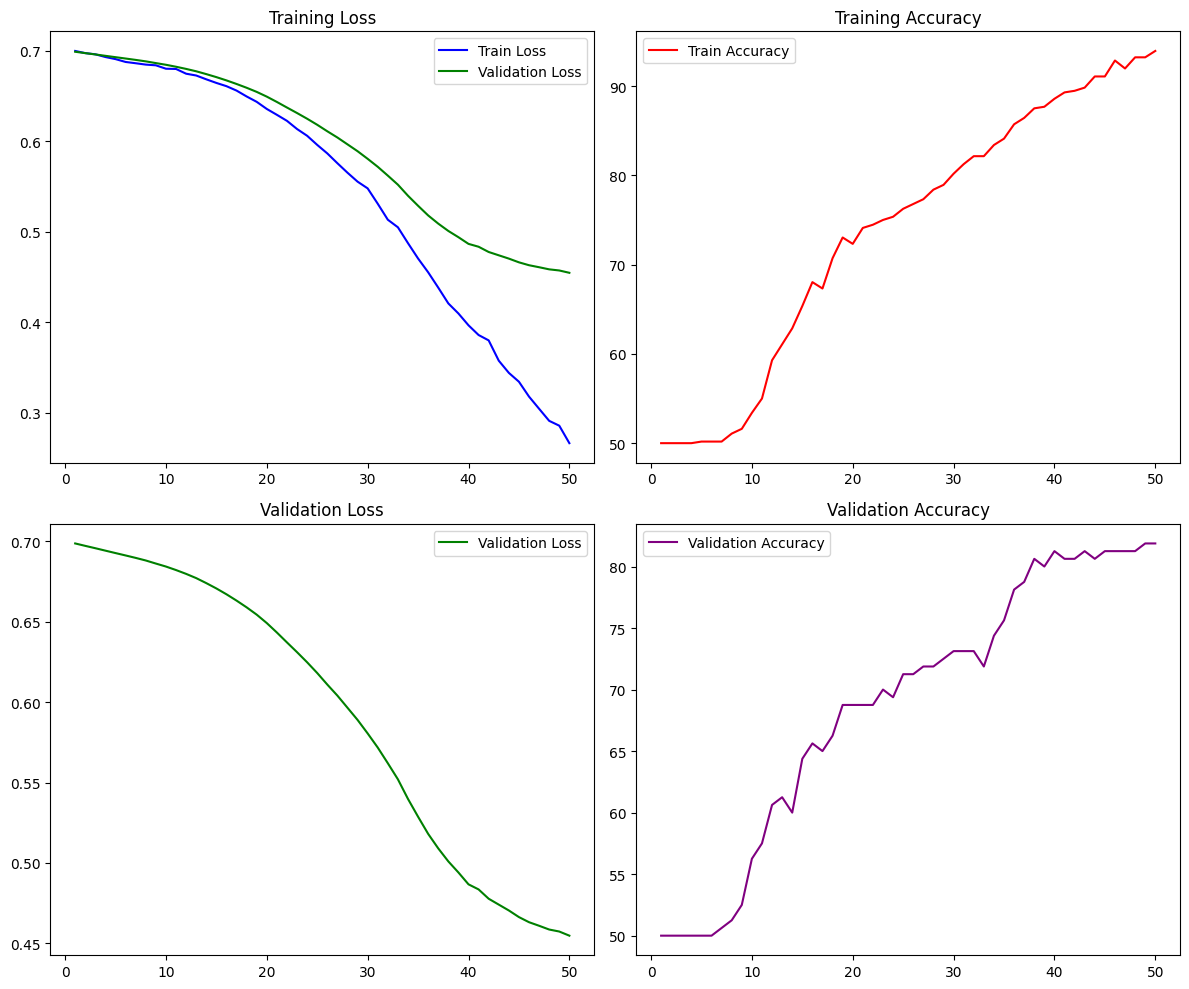

In [67]:
pipeline(X,y)